In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch

### Data Loading

In [10]:
df_orig = pd.read_csv(os.path.abspath("/home/sneha/airway_tree_pilot_clean.csv"))

In [11]:
df = df_orig.copy()
df.describe()

,idno,startbpid,endbpid,centerlinelength,angle,dircosx,dircosy,dircosz,avginnerarea,generation,weibel_generation
count,7.768300e+04,77683.000000,77683.000000,77683.000000,77454.000000,77683.000000,77683.000000,77683.000000,77683.000000,77683.000000,77683.000000
mean,5.986778e+06,149.658226,197.128509,10.614453,143.201617,-0.021328,0.056368,0.138202,11.161638,6.539384,7.338839
std,1.832951e+06,121.756964,130.566550,9.629416,24.407202,0.552013,0.542999,0.614584,25.017431,1.918851,2.273523
min,3.011950e+06,-1.000000,1.000000,0.498047,4.410540,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,4.017080e+06,51.000000,92.000000,4.138575,132.688500,-0.476731,-0.381630,-0.392263,4.149160,5.000000,6.000000
50%,7.012039e+06,120.000000,180.000000,8.742300,149.928000,0.000000,0.061056,0.229416,6.168230,7.000000,7.000000
75%,8.010528e+06,220.000000,280.000000,14.169850,160.462500,0.436436,0.497468,0.704271,10.071250,8.000000,9.000000
max,8.023336e+06,744.000000,747.000000,128.734000,180.000000,1.000000,1.000000,1.000000,2343.240000,16.000000,17.000000


In [12]:
df.isnull().sum()

idno                   0
anatomicalname         0
startbpid              0
endbpid                0
centerlinelength       0
angle                229
dircosx                0
dircosy                0
dircosz                0
avginnerarea           0
lobes                  0
generation             0
weibel_generation      0
manufacturer           0
model                  0
dtype: int64

In [13]:
# check df columns, keep only relevant (angles, area, centerlinelenght, idno, generation, start and end lobes, anatomical name)
cols_to_keep = ['idno', "anatomicalname", 'startbpid', 'endbpid', 'centerlinelength', 'weibel_generation', 'angle', 'dircosx', 'dircosy', 'dircosz', 'avginnerarea', 'lobes']
df = df[cols_to_keep]

In [14]:
# remove nans in key cols
# angle - remove nulls if NOT TRACHEA
df = df.loc[~((df.dircosx.isnull()) & (df.startbpid != -1))]
df.dropna(subset = ['idno', 'centerlinelength', 'startbpid', 'endbpid', 'weibel_generation'], inplace=True)

In [15]:
# TO ADD HERE: 
# rename cols for full df
# drop orphans
# drop gens higher than X? 

print(f"Final clean df has {df.idno.nunique()} participants and a total length of {len(df)}")

Final clean df has 227 participants and a total length of 77683


### Mode Exploration

In [ ]:
# INITIAL MODES
# mode orthog: angle between bp and previous bp is between 80-100 degrees and angle (min/max) ratio ~ 1 (bifurcation)
# mode planar: angle between bp and previous bp is between -10 -10 degrees ~ 1 (bifurcation)
# mode domain: angle ratio (min/max) < 0.75 and max angle < 160
# mode other.

In [265]:
df_clean = df.loc[(df.idno == 3011950) ].copy()#& (df.weibel_generation < 5)
# fill nans in angle
df_clean.fillna(0, inplace=True)

In [266]:
# add angles
df_clean["thetax_"] = np.arccos(df_clean.dircosx.values)*180/np.pi
df_clean["thetaz_"]  = np.arccos(df_clean.dircosz.values)*180/np.pi
df_clean["thetay_"] = np.arccos(df_clean.dircosy.values)*180/np.pi
df_clean['v_'] = df_clean.apply(lambda x:x[['dircosx', 'dircosy', 'dircosz']].to_list(),axis=1)

df_clean

,idno,anatomicalname,startbpid,endbpid,centerlinelength,weibel_generation,angle,dircosx,dircosy,dircosz,avginnerarea,lobes,thetax_,thetaz_,thetay_,v_
0,3011950,Trachea,-1,1,82.0393,0,0.0000,-0.012990,0.194850,0.980747,237.70400,CEN,90.744293,11.261237,78.764039,"[-0.01299, 0.19485, 0.980747]"
1,3011950,RMB,1,6,23.6456,1,144.8070,-0.498729,-0.142494,0.854965,140.56700,CEN,119.915947,31.244132,98.192189,"[-0.498729, -0.142494, 0.854965]"
2,3011950,LMB,1,7,50.7900,1,127.0430,0.787070,0.049192,0.614899,97.70850,CEN,38.087465,52.055418,87.180374,"[0.78707, 0.0491919, 0.614899]"
3,3011950,BronInt,6,19,19.7550,2,162.0700,-0.260820,0.026082,0.965035,108.49400,CEN,105.118724,15.195955,88.505442,"[-0.26082, 0.026082, 0.965035]"
4,3011950,RUL,6,18,13.9716,2,98.7818,-0.904762,-0.190476,-0.380952,60.53220,RUL,154.791248,112.392664,100.980564,"[-0.904762, -0.190476, -0.380952]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,3011950,-,284,289,18.7295,11,149.1230,0.306741,-0.083657,0.948109,4.42925,RLL,72.137063,18.538721,94.798784,"[0.306741, -0.0836567, 0.948109]"
281,3011950,-,287,290,17.3687,12,155.4810,-0.145479,0.800132,0.581914,4.77264,RLL,98.365018,54.414724,36.857291,"[-0.145479, 0.800132, 0.581914]"
282,3011950,-,287,291,14.6245,12,170.7050,0.272681,0.506408,0.818044,7.91250,RLL,74.176136,35.110533,59.575137,"[0.272681, 0.506408, 0.818044]"
283,3011950,-,288,292,15.7903,12,170.6210,-0.172005,0.412813,0.894427,7.19732,RLL,99.904414,26.565076,65.618334,"[-0.172005, 0.412813, 0.894427]"


In [267]:
per_bp = df_clean.groupby([pd.Grouper('idno'), pd.Grouper('startbpid')]).agg({
    lambda x:x.to_list() if len(x.to_list()) <=2 else np.nan
}).reset_index()
per_bp.columns = [a for a,b in per_bp.columns]

# drop any rows with > 3 / flag
display(per_bp.loc[per_bp.endbpid.isnull()])
display(df_clean.loc[df_clean.startbpid == 83])
per_bp.dropna(subset='endbpid', inplace=True)

,idno,startbpid,anatomicalname,endbpid,centerlinelength,weibel_generation,angle,dircosx,dircosy,dircosz,avginnerarea,lobes,thetax_,thetaz_,thetay_,v_
59,3011950,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,3011950,254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,idno,anatomicalname,startbpid,endbpid,centerlinelength,weibel_generation,angle,dircosx,dircosy,dircosz,avginnerarea,lobes,thetax_,thetaz_,thetay_,v_
117,3011950,-,83,126,10.35540,6,150.799,-0.786796,-0.121046,-0.605228,5.45781,RUL,141.887093,127.245250,96.952474,"[-0.786796, -0.121046, -0.605228]"
118,3011950,-,83,127,1.21464,6,108.247,-0.447214,0.000000,0.894427,-1.00000,RUL,116.565077,26.565076,90.000000,"[-0.447214, 0.0, 0.894427]"
119,3011950,-,83,172,6.67501,6,145.126,-0.808122,-0.505076,0.303046,5.44589,RUL,143.912849,72.359355,120.336398,"[-0.808122, -0.505076, 0.303046]"


In [268]:
# add branch plane angle
def get_plane(x):
    if len(x) == 2:
        return np.cross(x[0], x[1])
    else:
        print(len(x), x)
        return np.nan
    
per_bp['plane_v'] = per_bp['v_'].apply(lambda x: get_plane(x))


1 [[-0.01299, 0.19485, 0.980747]]


In [269]:
per_bp

,idno,startbpid,anatomicalname,endbpid,centerlinelength,weibel_generation,angle,dircosx,dircosy,dircosz,avginnerarea,lobes,thetax_,thetaz_,thetay_,v_,plane_v
0,3011950,-1,[Trachea],[1],[82.0393],[0],[0.0],[-0.01299],[0.19485],[0.980747],[237.704],[CEN],[90.74429310889138],[11.261236973713057],[78.76403885449696],"[[-0.01299, 0.19485, 0.980747]]",NaN
1,3011950,1,"[RMB, LMB]","[6, 7]","[23.6456, 50.79]","[1, 1]","[144.807, 127.043]","[-0.498729, 0.78707]","[-0.142494, 0.0491919]","[0.854965, 0.614899]","[140.567, 97.7085]","[CEN, CEN]","[119.91594688215824, 38.08746466549722]","[31.244131649834205, 52.055418183539345]","[98.19218908710424, 87.18037378765563]","[[-0.498729, -0.142494, 0.854965], [0.78707, 0...","[-0.1296767708895, 0.979585265921, 0.087619325..."
2,3011950,6,"[BronInt, RUL]","[19, 18]","[19.755, 13.9716]","[2, 2]","[162.07, 98.7818]","[-0.26082, -0.904762]","[0.026082, -0.190476]","[0.965035, -0.380952]","[108.494, 60.5322]","[CEN, RUL]","[105.11872359708731, 154.79124751497045]","[15.195955491383817, 112.39266419834142]","[88.50544199539189, 100.98056431059823]","[[-0.26082, 0.026082, 0.965035], [-0.904762, -...","[0.173880016596, -0.9724868973099999, 0.073277..."
3,3011950,7,"[LUL, LLB6]","[11, 10]","[12.0985, 8.43446]","[2, 2]","[115.366, 165.459]","[0.83205, 0.745356]","[-0.44376, 0.298142]","[-0.33282, 0.596285]","[60.5433, 146.8]","[LUL, LLL]","[33.69009792854607, 41.810314251195045]","[109.44002767462851, 53.39570885458844]","[116.34403118376271, 72.65395853751477]","[[0.83205, -0.44376, -0.33282], [0.745356, 0.2...","[-0.16537981116, -0.7442083181699999, 0.578828..."
4,3011950,10,"[LLB, LB6]","[15, 14]","[9.92149, 8.46466]","[3, 3]","[161.214, 114.776]","[0.57735, 0.40161]","[0.11547, 0.883541]","[0.80829, -0.240966]","[40.2393, 24.9217]","[LLL, LLL]","[54.735629207009254, 66.32113399706856]","[36.07080532432964, 103.94356146670238]","[83.36926533737976, 27.927492429231766]","[[0.57735, 0.11547, 0.80829], [0.40161, 0.8835...","[-0.74198169891, 0.463739067, 0.46373848965000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,3011950,268,"[-, -]","[283, 284]","[5.4788, 11.5766]","[10, 10]","[136.996, 134.994]","[0.11547, -0.0451294]","[0.80829, 0.315906]","[0.57735, 0.947717]","[6.62087, 13.2596]","[RLL, RLL]","[83.36926533737976, 92.58660266536]","[54.735629207009254, 18.60923274995946]","[36.07080532432964, 71.58448315518284]","[[0.11547, 0.80829, 0.57735], [-0.0451294, 0.3...","[0.5836418448299999, -0.13548834108000002, 0.0..."
138,3011950,283,"[-, -]","[286, 287]","[0.5, 5.59141]","[11, 11]","[125.264, 165.227]","[0.0, 0.212]","[0.0, 0.635999]","[1.0, 0.741999]","[-1.0, 6.44802]","[RLL, RLL]","[90.0, 77.76041684384778]","[0.0, 42.09802075322983]","[90.0, 50.50588212923461]","[[0.0, 0.0, 1.0], [0.212, 0.635999, 0.741999]]","[-0.635999, 0.212, 0.0]"
139,3011950,284,"[-, -]","[288, 289]","[12.7729, 18.7295]","[11, 11]","[179.22, 149.123]","[-0.0410305, 0.306741]","[0.328244, -0.0836567]","[0.943701, 0.948109]","[9.58158, 4.42925]","[RLL, RLL]","[92.35153459847726, 72.13706265996217]","[19.317319467834878, 18.53872124166107]","[70.8377719513192, 94.79878431378994]","[[-0.0410305, 0.328244, 0.943701], [0.306741, ...","[0.3901580020427, 0.3283731747655, -0.09725341..."
140,3011950,287,"[-, -]","[290, 291]","[17.3687, 14.6245]","[12, 12]","[155.481, 170.705]","[-0.145479, 0.272681]","[0.800132, 0.506408]","[0.581914, 0.818044]","[4.77264, 7.9125]","[RLL, RLL]","[98.36501799526206, 74.17613554596265]","[54.414723890885355, 35.11053272160808]","[36.85729072496308, 59.575136780197205]","[[-0.145479, 0.800132, 0.581914], [0.272681, 0...","[0.35985727689599994, 0.27768511451, -0.291852..."


In [270]:
def get_parent_vector_plane(x):
    v = np.array(per_bp['endbpid'].to_list()[1:]) # exclude trachea for the participant
    if np.any(np.isin(v,x.startbpid)):
        index = np.argmax(np.max(np.isin(v,x.startbpid), axis=1)) # find row that contains the parent branch (prev bpid)
        print(index)
        try:
            row_parent = per_bp.iloc[index+1] # adding 1 back on for the trachea
        except:
            print("Help", index, len(per_bp))
        return row_parent.plane_v
    else:
        return np.nan
def get_plane_rotation(x):
    dot_prod = np.dot(x.plane_v, x.parent_plane_v)/(np.linalg.norm(x.plane_v)*np.linalg.norm(x.parent_plane_v))
    rot_angle = np.arccos(dot_prod)*180/np.pi
    min_angle = np.min([rot_angle, 180-rot_angle])
    return min_angle
per_bp['parent_plane_v'] = per_bp.apply(lambda x: get_parent_vector_plane(x), axis=1)

per_bp['plane_rotation'] = per_bp.apply(
    lambda x: get_plane_rotation(x),
axis=1)
per_bp

0
0
2
2
3
3
4
4
1
1
5
5
6
6
7
7
8
8
9
9
10
10
11
12
13
13
14
14
16
16
17
17
18
18
19
19
20
20
21
21
22
22
24
25
25
26
26
27
31
32
32
33
33
34
35
35
36
37
37
38
38
39
39
40
40
41
41
42
42
45
47
49
50
51
52
54
55
56
57
58
58
59
61
61
62
62
64
64
65
66
66
67
67
68
69
69
70
71
73
74
75
76
79
79
83
85
86
91
92
93
93
95
95
96
96
97
98
103
104
105
108
113
113
115
116
116
119
123
125
126
126
127
127
134
134
135
136


,idno,startbpid,anatomicalname,endbpid,centerlinelength,weibel_generation,angle,dircosx,dircosy,dircosz,avginnerarea,lobes,thetax_,thetaz_,thetay_,v_,plane_v,parent_plane_v,plane_rotation
0,3011950,-1,[Trachea],[1],[82.0393],[0],[0.0],[-0.01299],[0.19485],[0.980747],[237.704],[CEN],[90.74429310889138],[11.261236973713057],[78.76403885449696],"[[-0.01299, 0.19485, 0.980747]]",NaN,NaN,NaN
1,3011950,1,"[RMB, LMB]","[6, 7]","[23.6456, 50.79]","[1, 1]","[144.807, 127.043]","[-0.498729, 0.78707]","[-0.142494, 0.0491919]","[0.854965, 0.614899]","[140.567, 97.7085]","[CEN, CEN]","[119.91594688215824, 38.08746466549722]","[31.244131649834205, 52.055418183539345]","[98.19218908710424, 87.18037378765563]","[[-0.498729, -0.142494, 0.854965], [0.78707, 0...","[-0.1296767708895, 0.979585265921, 0.087619325...",NaN,NaN
2,3011950,6,"[BronInt, RUL]","[19, 18]","[19.755, 13.9716]","[2, 2]","[162.07, 98.7818]","[-0.26082, -0.904762]","[0.026082, -0.190476]","[0.965035, -0.380952]","[108.494, 60.5322]","[CEN, RUL]","[105.11872359708731, 154.79124751497045]","[15.195955491383817, 112.39266419834142]","[88.50544199539189, 100.98056431059823]","[[-0.26082, 0.026082, 0.965035], [-0.904762, -...","[0.173880016596, -0.9724868973099999, 0.073277...","[-0.1296767708895, 0.979585265921, 0.087619325...",9.663900
3,3011950,7,"[LUL, LLB6]","[11, 10]","[12.0985, 8.43446]","[2, 2]","[115.366, 165.459]","[0.83205, 0.745356]","[-0.44376, 0.298142]","[-0.33282, 0.596285]","[60.5433, 146.8]","[LUL, LLL]","[33.69009792854607, 41.810314251195045]","[109.44002767462851, 53.39570885458844]","[116.34403118376271, 72.65395853751477]","[[0.83205, -0.44376, -0.33282], [0.745356, 0.2...","[-0.16537981116, -0.7442083181699999, 0.578828...","[-0.1296767708895, 0.979585265921, 0.087619325...",46.231274
4,3011950,10,"[LLB, LB6]","[15, 14]","[9.92149, 8.46466]","[3, 3]","[161.214, 114.776]","[0.57735, 0.40161]","[0.11547, 0.883541]","[0.80829, -0.240966]","[40.2393, 24.9217]","[LLL, LLL]","[54.735629207009254, 66.32113399706856]","[36.07080532432964, 103.94356146670238]","[83.36926533737976, 27.927492429231766]","[[0.57735, 0.11547, 0.80829], [0.40161, 0.8835...","[-0.74198169891, 0.463739067, 0.46373848965000...","[-0.16537981116, -0.7442083181699999, 0.578828...",87.217500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,3011950,268,"[-, -]","[283, 284]","[5.4788, 11.5766]","[10, 10]","[136.996, 134.994]","[0.11547, -0.0451294]","[0.80829, 0.315906]","[0.57735, 0.947717]","[6.62087, 13.2596]","[RLL, RLL]","[83.36926533737976, 92.58660266536]","[54.735629207009254, 18.60923274995946]","[36.07080532432964, 71.58448315518284]","[[0.11547, 0.80829, 0.57735], [-0.0451294, 0.3...","[0.5836418448299999, -0.13548834108000002, 0.0...","[-0.034218956920999966, 0.866889100111, -0.399...",73.205908
138,3011950,283,"[-, -]","[286, 287]","[0.5, 5.59141]","[11, 11]","[125.264, 165.227]","[0.0, 0.212]","[0.0, 0.635999]","[1.0, 0.741999]","[-1.0, 6.44802]","[RLL, RLL]","[90.0, 77.76041684384778]","[0.0, 42.09802075322983]","[90.0, 50.50588212923461]","[[0.0, 0.0, 1.0], [0.212, 0.635999, 0.741999]]","[-0.635999, 0.212, 0.0]","[0.5836418448299999, -0.13548834108000002, 0.0...",8.766100
139,3011950,284,"[-, -]","[288, 289]","[12.7729, 18.7295]","[11, 11]","[179.22, 149.123]","[-0.0410305, 0.306741]","[0.328244, -0.0836567]","[0.943701, 0.948109]","[9.58158, 4.42925]","[RLL, RLL]","[92.35153459847726, 72.13706265996217]","[19.317319467834878, 18.53872124166107]","[70.8377719513192, 94.79878431378994]","[[-0.0410305, 0.328244, 0.943701], [0.306741, ...","[0.3901580020427, 0.3283731747655, -0.09725341...","[0.5836418448299999, -0.13548834108000002, 0.0...",55.800306
140,3011950,287,"[-, -]","[290, 291]","[17.3687, 14.6245]","[12, 12]","[155.481, 170.705]","[-0.145479, 0.272681]","[0.800132, 0.506408]","[0.581914, 0.818044]","[4.77264, 7.9125]","[RLL, RLL]","[98.36501799526206, 74.17613554596265]","[54.414723890885355, 35.11053272160808]","[36.85729072496308, 59.57

In [ ]:
# def dfs(graph, node, visited):
#     if node not in visited:
#         visited.append(node)
#         for k in graph[node]:
#             dfs(graph,k, visited)
#     return visited

# visited = dfs(graph1,'A', [])
# print(visited)

In [273]:
# classify based on pairs of angles
per_bp['domain?'] = per_bp['angle'].apply(lambda x: True if ((np.max(x) > 160) & (np.min(x)/np.max(x)  <= 0.8)) else False) # one large angle
per_bp['bifurcation?']= per_bp['angle'].apply(lambda x: True if np.min(x)/np.max(x) > 0.8 else False) # similar angles for children = bifurcation
per_bp['other_mode?'] = ~(per_bp['domain?']|per_bp['bifurcation?'])
per_bp['planar_bi'] = per_bp['bifurcation?'] & (per_bp['plane_rotation'] <= 20)
per_bp['orthog_bi'] = per_bp['bifurcation?'] & (per_bp['plane_rotation'] >= 70)
per_bp['other_bi'] = ~(per_bp['planar_bi']| per_bp['orthog_bi']) & (per_bp['bifurcation?'])

In [275]:
per_bp[['bifurcation?', 'domain?', 'other_mode?', 'planar_bi', 'orthog_bi', 'other_bi']].sum()/len(per_bp)

bifurcation?    0.642857
domain?         0.228571
other_mode?     0.128571
planar_bi       0.064286
orthog_bi       0.257143
other_bi        0.321429
dtype: float64

In [277]:
per_bp['gen'] = (per_bp['weibel_generation'].apply(lambda x: np.nan if min(x) != max(x) else min(x)))

In [286]:
categories = per_bp.groupby('gen').agg({
    'domain?': sum,
    'bifurcation?': sum,
    'other_mode?':sum,
    'planar_bi': sum,
    'orthog_bi': sum,
    'other_bi':sum,
    'endbpid': "count"
}).reset_index()

<AxesSubplot:xlabel='gen'>

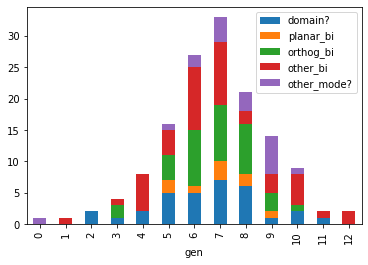

In [290]:
categories.plot.bar(x='gen', y=['domain?', 'planar_bi','orthog_bi', 'other_bi', 'other_mode?'], stacked=True)

<AxesSubplot:xlabel='weibel_generation'>

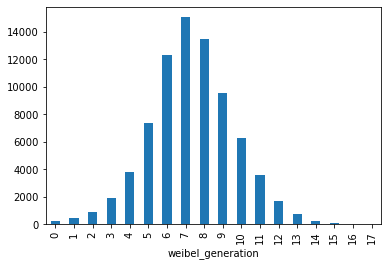

In [294]:
df.groupby('weibel_generation').count()["idno"].plot.bar()

In [224]:
'''
child's (dircosx, dircosy, dircosz) = relative position vector to add to parent vector to get child vector (unit vectors)
so branching angle ==> np.dot(parent dircos, child dircos)*180/np.pi = cos(theta)
angle is from heading dirn down (so its the major not minor angle) --> do 180-arccos(np.dot...) = branching angle

iterate through branching points
for each branching point in the list:
- check first domain vs birfucation of some sort (angle diff)
- for pairs of children do c1 cross c2 = vector pperp to plane containing the 2 vectors --> look at rotation between successive on path
- so for pairs of children do first comparision of angles (Bi or Domain or OTHER) and calc plane for the pair
- then iterate through the new df and look at adjacent pairs of and add marker for orthog / planar / other bifurcation

'''
parent =  df_clean.loc[df.endbpid==6]
print(parent)
parent_v = parent[['dircosx', 'dircosy', 'dircosz']].values.squeeze()
print(parent_v.shape)
child = df_clean.loc[df.endbpid==19]
print(child)
child_v = child[['dircosx', 'dircosy', 'dircosz']].values.squeeze()
180-np.arccos(np.dot(child_v, parent_v))*180/np.pi


      idno anatomicalname  startbpid  endbpid  centerlinelength  \
1  3011950            RMB          1        6           23.6456   

   weibel_generation    angle   dircosx   dircosy   dircosz  avginnerarea  \
1                  1  144.807 -0.498729 -0.142494  0.854965       140.567   

  lobes     thetax_    thetaz_    thetay_                                v_  
1   CEN  119.915947  31.244132  98.192189  [-0.498729, -0.142494, 0.854965]  
(3,)
      idno anatomicalname  startbpid  endbpid  centerlinelength  \
3  3011950        BronInt          6       19            19.755   

   weibel_generation   angle  dircosx   dircosy   dircosz  avginnerarea lobes  \
3                  2  162.07 -0.26082  0.026082  0.965035       108.494   CEN   

      thetax_    thetaz_    thetay_                              v_  
3  105.118724  15.195955  88.505442  [-0.26082, 0.026082, 0.965035]  


162.06995833892842